In [1]:
import os
import sys
import time
import datetime
import re
import multiprocessing
import ast

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}

# sns.set(rc=rc)

from scipy import ndimage as ndi
import scipy as scp
import pandas as pd

import matplotlib.animation as anm
from IPython.display import HTML

from skimage.external.tifffile import TiffWriter

from PIL import Image

import skimage.filters
import skimage.io
import skimage.morphology
import skimage.feature
import skimage.exposure

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh import palettes, transform

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 24, 
      'xtick.labelsize': 18, 
      'ytick.labelsize': 18, 
      'legend.fontsize': 18,
      'axes.facecolor': 'fbfbfc'}
sns.set_context('talk', rc=rc)

%matplotlib inline
output_notebook()

# nb_prefix = "/mnt/disks/movie-180831/20180831_1"
file_temp = "/mnt/disks/movie-180831/20180831_1/{}/img_{:09d}_{}_000.tif"

/opt/anaconda/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Loading BokehJS ...

In [2]:
# Channel information for IX81 inverted microscope
all_channel_inds = [str(xx) for xx in range(6)]
all_channel_names = ['Brightfield', 'GFP', 'YFP', 'mScarlet', 'unk', 'sfCFP']
all_channel_dict = dict(zip(all_channel_inds, all_channel_names))

def img_metadata_dict(img):
    '''Read metadata into dictionary from the TIFF metadata. 
    
        This function uses string replacements to read dictionary key-value pairs.
    
    '''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    return dict(zip(metadata_keys, metadata_vals))

def img_metadata_dict_full(img):
    '''Read metadata into dictionary from the TIFF metadata. 
    
        After some cleanup, this function reads the metadata string directly as a dictionary definition.
    '''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    in_str = metadata_str[9:].replace('\n','').replace('\s*','').replace('null','None').replace('false','True')
    out_dict = ast.literal_eval(in_str)
    return out_dict

def img_metadata(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata = img_metadata_dict(img)
    time_tuple = time.strptime(metadata['Time'],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple), metadata["Channel"]

def fn_metadata(fn):
    '''Wrapper for reading creation time from an image filename'''
    with Image.open(fn) as img:
        out = img_metadata(img)
    return out

def fn_metadata_full(fn):
    '''Wrapper for reading full metadata dictionary from a filename'''
    with Image.open(fn) as img:
        out = img_metadata_dict_full(img)
    return out

def get_time_vector_from_fn(fn):
    time_dict = dict(zip(channel,len(channel)*[]))
    with Image.open(fn) as img:
        try:
            while 1:
                ct, ch = img_metadata(img)
                time_dict[chan_dict[ch]].append(ct)
                img.seek(img.tell()+1)
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
    return time_dict

def get_data_from_frame(img):
    ct, ch = img_metadata(img)
    im_arr = np.array(list(img.getdata()),dtype=np.uint16).reshape(img.size[::-1])
    return ct, ch, im_arr

def get_movie_from_img(img):
    img_dict = dict(zip(channel,len(channel)*[]))
    time_dict = dict(zip(channel,len(channel)*[]))
    try:
        img.seek(0)
        while 1:
            ct, ch, im_arr = get_data_from_frame(img)
            ch = chan_dict[ch]
            img_dict[ch].append(im_arr)
            time_dict[ch].append(ct)
            img.seek(img.tell()+1)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    for key in img_dict:
        h, w = im_arr.shape
        img_dict[key] = np.vstack([x.reshape((1, h, w, 1)) for x in img_dict[key]])
    return img_dict, time_dict

def read_img(fn):
    with Image.open(fn) as img:
        return get_movie_from_img(img)
        
def concat_img_files(fn_list, fn_out):
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    with TiffWriter(fn_out, bigtiff=True) as tif:
        for fn in fn_list:
            eof_flag = True
            print("Writing ", fn)
            with Image.open(fn) as img:
                while eof_flag:
                    _, _, im_arr = get_data_from_frame(img)
                    img_md = img_metadata_dict(img)
                    for k in keep_keys:
                        metadata[k] = img_md[k]
                    metadata['Frame'] = int(os.path.basename(fn).split("_")[1])
                    h, w = im_arr.shape
                    tif.save(im_arr, metadata=metadata.copy())
                    try:
                        i += 1
                        img.seek(img.tell()+1)
                    except:
                        eof_flag = False
        
def convert_img_file(fn, fn_out):
    dirname = os.path.dirname(fn)
    fn_out = os.path.join(dirname, fn_out)
    ct = datetime.datetime.fromtimestamp(ctime(fn))
    eof_flag = True
    with Image.open(fn) as img:
        with TiffWriter(fn_out, bigtiff=True) as tif:
            while eof_flag:
                _, _, im_arr = get_data_from_frame(img)
                metadata = img_metadata_dict(img)
                tif.save(im_arr, datetime=ct, metadata=metadata)
                try:
                    img.seek(img.tell()+1)
                except:
                    eof_flag = False
    
def process_file(fn, skip=0):
    with Image.open(fn) as img:
        eof_flag = True
        column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
        df = pd.DataFrame(columns = column_names)
        try:
            while eof_flag:
                acq_dict = {}
                for i in range(3):
                    ct, ch, im_arr = get_data_from_frame(img)
#                     ch = chan_dict[ch]
                    acq_dict[ch] = (ct, im_arr)
                    try:
                        img.seek(img.tell()+1)
                    except EOFError:
                        eof_flag = False
                rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
                for col_i in range(num):
                    df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                    df = df.append(pd.DataFrame(df_dict), ignore_index=True)
                try:
                    img.seek(img.tell()+3*skip)
                except EOFError:
                    eof_flag = False
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
        df.to_csv(fn+".csv")
    return df

    
def process_file_skimage(fn):
    time_vec = get_time_vector_from_fn(fn)['"Brightfield"']
    im = skimage.io.imread(fn)
    column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns = column_names)
    try:
        while eof_flag:
            acq_dict = {}
            for i in range(3):
                ct, ch, im_arr = get_data_from_frame(img)
                acq_dict[ch] = (ct, im_arr)
                try:
                    img.seek(img.tell()+1)
                except EOFError:
                    eof_flag = False
            rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
            for col_i in range(num):
                df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    except KeyError:
        pass
    df.to_csv(fn+".csv")
    return df

def ctime(fname):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 50839
    with Image.open(fname) as img:
        metadata_str = img.tag_v2[50839].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    metadata = dict(zip(metadata_keys, metadata_vals))

    time_tuple = time.strptime(metadata['Time'],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple)

def crop(img):
    w, h = img.shape
    if w > 1000:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    return(img[y1:y2,x1:x2])

def uncrop(img):
    w, h = img.shape
    if w > 800:
        out_img = np.zeros((512*2, 672*2))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        out_img = np.zeros((512, 672))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    out_img[y1:y2,x1:x2] = img
    return(out_img)

def label_image(im_arr):
    im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
    w, h = im_arr.shape

    # Convert the uneven image to floating point
    im_float = im_arr
    # Smooth to reduce noise
    g_radius = 5
    im_smooth = skimage.filters.gaussian(im_float, g_radius)
    im_bgsub = im_float - im_smooth

    # Perform the median filter
    selem = skimage.morphology.square(4)
    im_bgsub = skimage.filters.median(im_bgsub, selem) / 4096.0
    
    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

    # Edge detection
    im_edge = skimage.filters.sobel(im_adj)
    im_edge = skimage.exposure.equalize_adapthist(im_adj)

    # Remove small objects and fill holes
    if np.all(im_edge == im_edge[0,0]) or np.any(np.isnan(im_edge)):
        return np.zeros((w,h)), 1
    thresh = skimage.filters.threshold_otsu(im_edge)
    selem = skimage.morphology.square(2)
    im_bw = skimage.morphology.binary_dilation(im_edge > thresh, selem)
    selem = skimage.morphology.square(12)
    im_bw = skimage.morphology.binary_closing(im_bw, selem)
    
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=10)
    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def get_fluors(bfi, rfp, gfp):
    im_labeled, num = label_image_2(bfi)
    num  = im_labeled.max()
#     rfp, gfp = [crop(x) for x in [rfp, gfp]]
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    gfp_bg = np.mean(gfp[im_labeled == 0])
    rfp_bg = np.mean(rfp[im_labeled == 0])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg

def read_tiff_file(fn, skip=0):
    print("Begin " + fn)
    df = process_file(fn, skip=skip)
    df.to_csv(fn+".csv", index=False)
    print("Finished " + fn)

def par_worker(fn_list, skip=1):
    for fn in fn_list:
        read_tiff_file(fn, skip=skip)
    

In [3]:
with skimage.external.tifffile.TiffFile('fullmovie_nomask.tif') as img:
    im_all = img.asarray(memmap=True)
print(im_all.shape)
# # with skimage.external.tifffile.TiffFile('180711_fullmovie_masksonly.tif') as img:
# #     im_masks = img.asarray(memmap=True)
    
# t_df = pd.read_csv('{}_time.csv'.format(nb_prefix))

# print(all_metadata.keys())
# [all_channel_dict[xx] for xx in chan_ind]

(12, 12, 3, 1024, 1024)


          x        y  label   pos  pad strain
1  -54332.0 -21330.7   Pos1   1.0  0.0    pCR
2  -56356.6  10644.7   Pos2   2.0  1.0    pCR
4  -37192.7   9502.6   Pos4   4.0  2.0    pCR
6  -34601.6 -14530.8   Pos6   6.0  3.0    pCR
8  -15348.1 -16225.6   Pos8   8.0  4.0    pCR
11 -13689.4  14700.1  Pos11  11.0  5.0    pCR
          x        y  label   pos  pad strain
0  -48433.5 -15535.8   Pos0   0.0  0.0    pRC
3  -47046.0  10451.3   Pos3   3.0  1.0    pRC
5  -29241.4   9432.9   Pos5   5.0  2.0    pRC
7  -31742.6 -11714.7   Pos7   7.0  3.0    pRC
9  -13976.1  -8202.6   Pos9   9.0  4.0    pRC
10 -14124.5   5864.8  Pos10  10.0  5.0    pRC


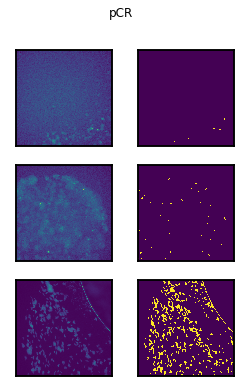

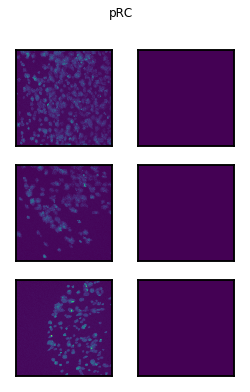

In [23]:
# Compare fluorescence channels to colony masks, from subsampled movie
n_pos_sub = im_all.shape[1]
n_frames_sub = im_all.shape[0]
def comp_strain_masks(strain, chan):
    gfp_fig, gfp_axs = plt.subplots(3,2,figsize=(4,6),sharex=True,sharey=True)
    gfp_ind_list = np.arange(n_pos)[cor_pos_df.strain == strain]
    print(cor_pos_df.iloc[gfp_ind_list,:])
    for plot_ind in np.arange(im_all.shape[1]//2):
        pos_ind = gfp_ind_list[plot_ind]
        fluor_arr = im_all[6,pos_ind,chan,:,:]
        col_arr = im_all[6,pos_ind,n_chan,:,:]
        ax = gfp_axs[plot_ind, 0]
        ax.imshow(fluor_arr)
        ax = gfp_axs[plot_ind, 1]
        ax.imshow(col_arr>0)
        ax.set_xticks([])
        ax.set_yticks([])
    gfp_fig.suptitle(strain)
comp_strain_masks('pCR',1)
comp_strain_masks('pRC',2)

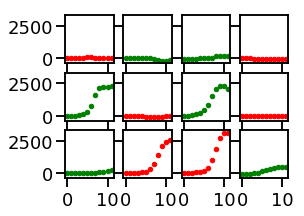

In [40]:
# View field-of-view-averaged fluorescence traces
fig, axs = plt.subplots(3,4,figsize=(4,3),sharex=True,sharey=True)
# fov_meaned_arr = im_all.mean(axis=3).mean(axis=3)
gfp_min_trace = 1#np.arange(n_pos)[fov_meaned_arr[-1,:,1].min() == fov_meaned_arr[-1,:,1]][0]
rfp_min_trace = 0#np.arange(n_pos)[fov_meaned_arr[-1,:,2].min() == fov_meaned_arr[-1,:,2]][0]
for plot_ind in np.arange(n_pos):
    ax = axs[plot_ind//4, np.mod(plot_ind,4)]
    if cor_pos_df.loc[plot_ind, 'strain'] == 'pCR':
        gfp_trace = fov_meaned_arr[:,plot_ind,1] - fov_meaned_arr[:,[1,2],1].mean(axis=1)
        ax.plot(gfp_trace, '.g')
    else:
        rfp_trace = fov_meaned_arr[:,plot_ind,2] - fov_meaned_arr[:,[0,3],2].mean(axis=1)
        ax.plot(rfp_trace, '.r')
#     ax.set_xticks([])
#     ax.set_yticks([])


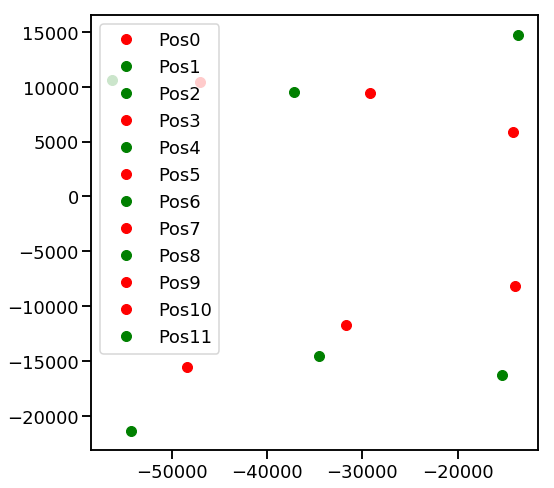

In [4]:
# Extract movie metadata
all_metadata = fn_metadata_full(file_temp.format('Pos0',0,0))
summ_dict = all_metadata['Summary']
chan_ind = summ_dict['ChNames']
chan_int = [int(xx) for xx in chan_ind]
n_chan = len(chan_ind)
chan_int_dict = dict(zip(chan_int, np.arange(n_chan)))
chan_name = [all_channel_dict[xx] for xx in chan_ind]
n_pos = summ_dict['Positions']
n_frames = summ_dict['Frames']
im_width = summ_dict['Width']
im_height = summ_dict['Height']

# Cor_pos_df is corrected position DF. In this notebook, correcting the position is not
# necessary as there are only two imaging positions per pad.
cor_pos_df = pd.DataFrame(np.empty((n_pos,6)),columns=['x','y','label', 'pos', 'pad', 'strain'])
for p_i in np.arange(n_pos):
    x, y = summ_dict['InitialPositionList'][p_i]['DeviceCoordinatesUm']['XYStage']
    label = summ_dict['InitialPositionList'][p_i]['Label']
    cor_pos_df.loc[p_i,['x', 'y', 'label', 'pos']] = [x, y, label, p_i]

for pos in np.arange(n_pos):
    cor_pos_df.loc[pos,'pad'] = np.floor(pos//2)

# Judging from the movie data, these are the strains at each position
for pos in np.arange(n_pos):
    if pos in [0,3,5,7,9,10]:
        cor_pos_df.loc[pos, 'strain'] = 'pRC'
    else:
        cor_pos_df.loc[pos, 'strain'] = 'pCR'
    
def dist_f(pad_ind):
    '''
    Calculates distance between colonies for input pad index
    '''
    pos_arr = cor_pos_df.loc[cor_pos_df.pad == 3, ['x', 'y']].values
    dist = np.sqrt(np.sum(np.power(np.diff(pos_arr, axis=0),2)))
    return dist
    
plt.figure(figsize=(8,8))
for p_i in np.arange(n_pos):
    if cor_pos_df.loc[p_i, 'strain'] == 'pRC':
        point_color='r'
    else:
        point_color = 'g'
    plt.plot(np.float(cor_pos_df.x[p_i]), 
             np.float(cor_pos_df.y[p_i]), 
             '.', 
             label=cor_pos_df.label[p_i],
             ms=20,
             c=point_color)
plt.legend()

In [41]:
im_vec = [skimage.external.tifffile.TiffFile(file_temp.format('Pos5',50,chan)).asarray(memmap=True) for chan in [1,3]]
im_ex = im_vec[1]

im_arr = im_ex
# plt.imshow(im_arr)
# plt.figure()


im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
w, h = im_arr.shape

# Convert the uneven image to floating point
im_float = im_arr
# Smooth to reduce noise
g_radius = 5
im_smooth = skimage.filters.gaussian(im_float, g_radius)
im_bgsub = im_float - im_smooth

# Perform the median filter
selem = skimage.morphology.square(4)
im_bgsub = skimage.filters.median(im_bgsub, selem) / 4096.0

# Adjust exposure
im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

# Edge detection
im_edge = skimage.filters.sobel(im_adj)
im_edge = skimage.exposure.equalize_adapthist(im_adj)

# Remove small objects and fill holes
thresh = skimage.filters.threshold_otsu(im_edge)
selem = skimage.morphology.square(2)
im_bw = skimage.morphology.binary_dilation(im_edge > thresh, selem)
selem = skimage.morphology.square(12)
im_bw = skimage.morphology.binary_closing(im_bw, selem)

im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=10)
im_labeled, num = skimage.morphology.label(im_bw, return_num=True)

# plt.imshow(im_labeled)
print(im_arr.dtype)
print(num)

# titles = ("im_arr", "im_bgsub", "im_edge", "im_edge2", "im_bw")
# plots = (im_arr, im_bgsub, im_edge, im_edge>thresh, im_bw)
# for im, title in zip(plots, titles):
#     plt.figure(figsize=(5,5))
#     plt.imshow(im)
#     plt.title(title)

# plt.figure()
# _ = plt.hist(im_edge.flatten(), bins=200)

/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


float64
111


In [ ]:
# Scrape metadata

def make_tdf():
    template = "/mnt/disks/timelapse-movies/180831/20180831_1/{}/img_{:09d}_0_000.tif"
    i = 0
    t_skip = 1
    t_points = np.arange(0,n_frames,t_skip)
    t_len = len(t_points)
    p_skip = 1
    p_points = np.arange(0,n_pos,p_skip)
    p_len = len(p_points)
    t_df = pd.DataFrame(np.empty((n_frames*n_pos,3)), columns=['frame', 'pos', 'time'])
    for p_i in p_points:
        for t_i in t_points:
            fn = template.format(cor_pos_df.loc[p_i,'label'], t_i)
            t_df.loc[i,:] = np.array([t_i, p_i, ctime(fn)])
            i += 1
    t_df.to_csv('{}_time.csv'.format(nb_prefix), index=False)


# make_tdf()
t_df = pd.read_csv('{}_time.csv'.format(nb_prefix))

In [6]:
# Make a tiff image stack without a mask channel
def make_movie(fn_out, t_skip=10, p_skip=1):
    # I don't think this works but keep a metadata dictionary to store useful metatdata in 
    # the output video
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    # Set indices
    i = 0
    t_points = np.arange(0,n_frames,t_skip)
    t_len = len(t_points)
    p_points = np.arange(0,n_pos,p_skip)
    p_len = len(p_points)
    im_out = np.zeros((t_len,p_len,n_chan,im_height,im_width,1), dtype=np.uint16)
    # Write movie to file
    with TiffWriter(fn_out, imagej=True, append=False) as tif:
        for tp in t_points:
            for pp in p_points:
                # position label is used to complete filename
                # strain is used to determine which fluorescence channel to use for segmentation
                pos_str, strain = cor_pos_df.loc[pp, ['label', 'strain']]
                for cp in chan_int:
                    fn = file_temp.format(pos_str, tp, cp)
                    eof_flag = True
                    print("Writing ", fn)
                    with Image.open(fn) as img:
                        while eof_flag:
                            _, _, im_arr = get_data_from_frame(img)
                            if im_arr.shape[0] > 2000:
                                im_arr = np.round(skimage.transform.downscale_local_mean(im_arr, (2,2)))
                            im_arr = im_arr.astype(np.float32).astype(np.uint16)
                            img_md = img_metadata_dict_full(img)
                            for k in keep_keys:
                                metadata[k] = img_md[k]
                            h, w = im_arr.shape
                            im_out[tp//t_skip, pp//p_skip, chan_int_dict[cp], :, :, 0] = im_arr
                            try:
                                i += 1
                                img.seek(img.tell()+1)
                            except:
                                eof_flag = False
        tif.save(im_out, metadata=metadata.copy())

# make_movie('fullmovie_nomask.tif')

In [7]:
# Make a tiff image stack with a mask channel
def make_movie(fn_out, t_skip=10, p_skip=1, n_pos=n_pos,n_frames=n_frames):
    # I don't think this works but keep a metadata dictionary to store useful metatdata in 
    # the output video
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    # Set indices
    i = 0
    t_points = np.arange(0,n_frames,t_skip)
    t_len = len(t_points)
    p_points = np.arange(0,n_pos,p_skip)
    p_len = len(p_points)
    im_out = np.zeros((t_len,p_len,n_chan+1,im_height,im_width,1), dtype=np.uint16)
    # Write movie to file
    with TiffWriter(fn_out, imagej=True, append=False) as tif:
        for tp in t_points:
            for pp in p_points:
                # position label is used to complete filename
                # strain is used to determine which fluorescence channel to use for segmentation
                pos_str, strain = cor_pos_df.loc[pp, ['label', 'strain']]
                if strain == 'pCR':
                    segment_channel = 1 # gfp channel
                else:
                    segment_channel = 2 # rfp channel
                for cp in chan_int:
                    pos_str = cor_pos_df.loc[pp, 'label']
                    fn = file_temp.format(pos_str, tp, cp)
                    eof_flag = True
                    print("Writing ", fn)
                    with Image.open(fn) as img:
                        while eof_flag:
                            # Get image array
                            _, _, im_arr = get_data_from_frame(img)
                            # Label image
                            if cp == segment_channel:
                                im_lab, col_num = label_image(im_arr)
                                im_out[tp//t_skip, pp//p_skip, n_chan, :, :, 0] = im_lab.astype(np.uint16)
                            # Downscale if image width is more than 2000 pixels
                            if im_arr.shape[0] > 2000:
                                im_arr = np.round(skimage.transform.downscale_local_mean(im_arr, (2,2)))
                            im_arr = im_arr.astype(np.float32).astype(np.uint16)
                            # I'm not sure this works but keep image metadata for the current frame
                            img_md = img_metadata_dict_full(img)
                            for k in keep_keys:
                                metadata[k] = img_md[k]
                            h, w = im_arr.shape
                            im_out[tp//t_skip, pp//p_skip, chan_int_dict[cp], :, :, 0] = im_arr
                            try:
                                i += 1
                                img.seek(img.tell()+1)
                            except:
                                eof_flag = False
        tif.save(im_out, metadata=metadata.copy())

make_movie('fullmovie_mask.tif', n_frames=80, n_pos=6)

Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000000_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000000_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000000_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000000_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000000_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/exposure/exposure.py:297: RuntimeWarning: invalid value encountered in true_divide
  image = (image - imin) / float(imax - imin)
/opt/anaconda/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000000_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000000_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000000_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000000_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000000_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000000_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000000_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000000_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000000_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000000_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000000_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000000_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000000_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000010_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000010_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000010_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000010_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000010_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000010_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000010_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000010_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000010_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000010_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000010_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000010_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000010_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000010_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000010_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000010_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000010_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000010_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000020_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000020_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000020_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000020_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000020_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000020_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000020_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000020_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000020_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000020_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000020_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000020_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000020_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000020_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000020_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000020_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000020_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000020_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000030_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000030_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000030_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000030_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000030_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000030_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000030_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000030_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000030_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000030_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000030_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000030_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000030_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000030_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000030_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000030_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000030_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000030_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000040_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000040_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000040_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000040_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000040_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000040_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000040_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000040_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000040_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000040_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000040_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000040_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000040_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000040_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000040_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000040_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000040_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000040_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000050_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000050_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000050_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000050_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000050_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000050_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000050_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000050_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000050_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000050_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000050_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000050_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000050_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000050_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000050_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000050_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000050_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000050_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000060_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000060_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000060_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000060_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000060_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000060_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000060_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000060_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000060_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000060_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000060_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000060_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000060_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000060_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000060_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000060_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000060_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000060_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000070_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000070_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos0/img_000000070_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000070_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000070_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos1/img_000000070_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000070_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000070_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos2/img_000000070_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000070_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000070_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos3/img_000000070_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000070_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000070_1_000.tif


/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/movie-180831/20180831_1/Pos4/img_000000070_3_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000070_0_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000070_1_000.tif
Writing  /mnt/disks/movie-180831/20180831_1/Pos5/img_000000070_3_000.tif


In [6]:
import matplotlib.animation as anm
from IPython.display import HTML

# img = skimage.io.imread(f_names[2])
def write_movie(img, skip=10, pos=3):
    plt.close('all')
    
    t_points, s, c, h, w = img.shape
    t_vec = np.arange(0, t_points, skip)
    frames = len(t_vec)
    #t_list = list(t_vec[-1::-1]) + [-1]
    
    t_list = np.arange(t_points)
    
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,2, figsize=(10,8))
    im_list = [0,0,0,0]
    
    # initialize plots
    titles = ['bf', 'mscarlet', 'sfcfp', 'lab']
    vmaxs = [2.8e4  , 3e3, 3e3, 1]
    vmins = [1e4, 4e2, 4e2, 0]
    for i in np.arange(3):
        ax = axs[i//2, np.mod(i,2)]
        indxs = [i]
        vmax = vmaxs[i]
        vmin = vmins[i]
        im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')
        cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i])
        im_list[i] = im
    
    fig.tight_layout()
    
    # animation function.  This is called sequentially
    frame_arr = np.zeros((h,w))
    def animate(i):
        # Plot 
        for j in np.arange(3):
            ax = axs[j//2, np.mod(j,2)]
            frame_arr = img[i*skip,pos,j,:,:]#.sum(axis=0)
            im_list[j].set_array(frame_arr)

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=100, frames=frames)


    # Set up formatting for the movie files
    #Writer = anm.writers['ffmpeg_file']
    #writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=900, extra_args=['-vcodec', 'libx264'])

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    #anim.save('animation_{}.mp4'.format(fn), extra_args=['-vcodec', 'libx264'], dpi=50, writer=writer)
    #plt.close('all')


    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())
    

# with skimage.external.tifffile.TiffFile('180320_fullmovie_masktry.tif') as img:
#     im_all = img.asarray()
anim = write_movie(im_all, skip=1, pos=4)
HTML(anim.to_html5_video())

ValueError: Invalid file object: <_io.BufferedReader name=50>

In [ ]:
t, s, c, h, w = im_all.shape
im_out = np.zeros((t,3,h,5*w), dtype=np.float32)

# First set up the figure, the axis, and the plot element we want to animate
blank_array = np.zeros([h, 5*w, 3])
gray_array = np.ones([h, w, 3])
red_array = np.zeros([h, w, 3])
red_array[:,:,0] = np.ones([h, w])
red_array[:,:,1] = np.ones([h, w]) * 0
red_array[:,:,2] = np.ones([h, w]) * 0.
cyan_array = np.zeros([h, w, 3])
cyan_array[:,:,0] = np.ones([h, w]) * 0
cyan_array[:,:,1] = np.ones([h, w]) 
cyan_array[:,:,2] = np.ones([h, w])
i=70
# Plot cell densities
min_v = [10e3, 100, 100]
max_v = [30e3, 500, 500]
plt.figure(figsize=(15,3))
# Plot cell densities
frame = np.zeros([h, 5*w, 3])
for c, c_array in enumerate([gray_array, red_array, cyan_array]):
    for p, p_i in enumerate([5,4,3]):
        d_arr = (im_all[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#         d_arr[d_arr > 1 ] = 1
#         d_arr[d_arr < 0 ] = 0
        frame[:,(2*w*p):(2*w*(1+p)-w),:] += c_array * np.stack(3*[d_arr], axis=2)
frame[frame > 1 ] = 1
frame[frame < 0 ] = 0
plt.imshow(frame)


In [ ]:
with skimage.external.tifffile.TiffFile('mask_images/mask_44_13.tif') as img:
    im_mask = img.asarray(memmap=True)
_ = plt.imshow(im_mask)

In [ ]:
#
#  Use masks to track fluorescence of microcolonies
#

import matplotlib.animation as anm
from IPython.display import HTML

def par_worker(im_arr, t_df, fn_out):
    img_temp = "mask_images/mask_{:02d}_{:1d}.tif"
    column_names = ('frame','time', 'pos', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns=column_names)
    t, s, _, h, w = im_arr.shape
    t_df_piv = t_df.pivot('frame', 'pos', 'time')
    for t_i in range(0,t,1):
        i_frame = t_df.index[t_i]
        for s_i in range(s):
            ct = t_df_piv.loc[i_frame, s_i]
#             im_labeled, num = label_image_2(im_arr[t_i, s_i, 1:2,:,:].sum(axis=0))
            rfps, gfps, sizes, num, gfp_bg, rfp_bg, im_labeled = get_fluors_2(im_arr[t_i,s_i,1,:,:], 
                                                                              im_arr[t_i,s_i,2,:,:])
            img_fn = img_temp.format(i_frame, s_i)
            skimage.io.imsave(img_fn, im_labeled.astype(np.uint8))
#             for col_i in range(num):
#                 df_dict = dict(zip(column_names, [[i_frame],[ct], [s_i], [col_i], [gfps[col_i]], [rfps[col_i]], [sizes[col_i]], [gfp_bg], [rfp_bg]]))
#                 df = df.append(pd.DataFrame(df_dict), ignore_index=True)
#     df.to_csv(fn_out)
    print("wrote ", fn_out)

fn_temp = "processed_part_masktry_{}.csv"
fn_outs = [fn_temp.format(i) for i in range(4)]

jobs = []
for i in [0,1,2,3]:
    p = multiprocessing.Process(target=par_worker, 
                                args=(im_all[i::4,:,:,:,:], 
                                t_df.loc[i::4,:], fn_outs[i]))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")

In [ ]:
#
# Simply take means of the full field of view
#

def par_worker(im_arr, t_vec, fn_out):
    column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
    df = pd.DataFrame(columns=column_names)
    t, s, _, h, w = im_arr.shape
    for t_i in range(0,t,1):
        for s_i in range(s):
            ct = t_vec[t_i]
            df_dict = dict(zip(column_names, [[ct], [s_i], [im_arr[t_i,s_i,2,:,:].mean()], [im_arr[t_i,s_i,1,:,:].mean()]]))
            df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    df.to_csv(fn_out)
    print("wrote ", fn_out)

# t_df = pd.read_csv('time.csv', index_col=None)
t_piv = t_df.pivot('frame', 'pos', 'time')
fn_temp = "full_image_part_2_{}.csv"
fn_outs = [fn_temp.format(i) for i in range(4)]

jobs = []
for i in [0,1,2,3]:
    p = multiprocessing.Process(target=par_worker, 
                                args=(im_all[i::4,:,:,:,:], 
                                t_piv.values[i::4,0], fn_outs[i]))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")

In [ ]:
temp = 'processed_part_masktry_{}.csv'
column_names = ('time', 'pos', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
df = pd.DataFrame(columns=column_names)
for fn in [temp.format(i) for i in range(4)]:
    df = df.append(pd.read_csv(fn, dtype=np.float), ignore_index=True)

df.head(10)

In [ ]:
temp = 'processed_part_masktry_{}.csv'
column_names = ('time', 'pos', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
df = pd.DataFrame(columns=column_names)
for fn in [temp.format(i) for i in range(4)]:
    df = df.append(pd.read_csv(fn), ignore_index=True)
t_df_piv = t_df.pivot('frame', 'pos', 'time')
for i in np.arange(df.shape[0]):
    i_frame, i_pos = df.loc[i, ["frame","pos"]]
    df.loc[i,'time'] = t_df_piv.loc[np.int(i_frame), i_pos]
df.to_csv('{}_masktry_df_2.csv'.format(nb_prefix))

In [ ]:
# df = pd.read_csv('{}_masktry_df.csv'.format(nb_prefix))
fig, ax = plt.subplots(1,1,figsize=(5,4))
t_min = df.time.min()
ind = (df.pos == 4) & (df.colony>1) & (df.colony<10) # & (np.mod(df.colony,  5)==0 )
df_tmp = df.loc[ind,:]
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.mscarlet,'r.')
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.sfcfp,'c.')
ax.scatter(x=(df_tmp.time - t_min)/3600, 
           y=df_tmp.col_size,
           alpha=1, cmap='viridis')
new_t_vec = np.sort(np.unique(df_tmp.time - t_min))
r_c = (7e-3)/60
for i in np.arange(50,210,50):
    ax.plot(new_t_vec/3600, i*np.exp(new_t_vec*r_c),'k-')
# ax.set_facecolor('gray')
ax.set_ylim([-1e1,200])
ax.set_yticks(np.arange(0,601,200))
ax.set_ylabel('Colony area (pixels)')
ax.set_xlabel('Time (hours)')
ax.set_xticks(np.arange(0,4,1))
fig.tight_layout()
fig.savefig("microscope_cellgrowth.png", dpi=150, transparent=True)
fig.savefig("microscope_cellgrowth.pdf")
# fig, ax = plt.subplots(1,1,figsize=(9,9))
# # ind = (df.time < (6*60*60 + t_min)) & (df.pos == 3)
# # df_tmp = df.loc[ind,:]
to_full_screen = np.log((1024**2)/67057)/r_c
print(to_full_screen / 3600)
print((df.time.max() - t_min)/3600)
print(df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())
print((df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())/(1024**2))
# ax.scatter(x=df_tmp.mscarlet, 
#            y=df_tmp.sfcfp,
#            c=df_tmp.time,alpha=0.3, cmap='viridis')
# ax.set_facecolor('gray')
# (df_tmp.time[df_tmp.sfcfp > 200].min() - df_tmp.time[df_tmp.mscarlet > 200].min())


In [ ]:

fig, ax = plt.subplots(1,1,figsize=(10,4))
t_min = df.time.min()
ind = np.isclose(df.pos.astype(np.int), 21)
df_tmp = df.loc[ind,:]
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.mscarlet,'r.')
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.sfcfp,'c.')
ax.scatter(x=(df_tmp.time - t_min)/3600, 
           y=df_tmp.mscarlet,#/ 
#            c=df_tmp.mscarlet,
           alpha=1)#, cmap='viridis')
ax.set_ylim([0,1.5e3])
new_t_vec = np.sort(np.unique(df_tmp.time - t_min))
r_c = (7e-3)/60
# for i in np.arange(50,210,50):
#     ax.plot(new_t_vec/3600, i*np.exp(new_t_vec*r_c),'k-')
# ax.set_facecolor('gray')
# ax.set_ylim([600,800])

# ax.set_yticks(np.arange(0,601,200))
ax.set_ylabel('Colony area (pixels)')
ax.set_xlabel('Time (hours)')
# ax.set_xticks(np.arange(4,8,1))
# ax.set_xlim([0,800])
fig.tight_layout()
# fig.savefig("microscope_cellgrowth.png", dpi=150, transparent=True)
# fig.savefig("microscope_cellgrowth.pdf")
# fig, ax = plt.subplots(1,1,figsize=(9,9))
# # ind = (df.time < (6*60*60 + t_min)) & (df.pos == 3)
# # df_tmp = df.loc[ind,:]
to_full_screen = np.log((1024**2)/67057)/r_c
print(to_full_screen / 3600)
print((df.time.max() - t_min)/3600)
print(df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())
print((df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())/(1024**2))
# ax.scatter(x=df_tmp.mscarlet, 
#            y=df_tmp.sfcfp,
#            c=df_tmp.time,alpha=0.3, cmap='viridis')
# ax.set_facecolor('gray')
# (df_tmp.time[df_tmp.sfcfp > 200].min() - df_tmp.time[df_tmp.mscarlet > 200].min())


In [ ]:
df.pos.astype(np.int)

In [ ]:
from scipy import optimize as opt
def f_fun(p, t):
    c0,c1,c2 = p
    return c0 + c1 * (t)**c2

def f_res(p, t, fit_x):
    c0,c1,c2 = p
    if c1 < 0:
        return np.inf
    if c2 < 0:
        return np.inf
    res = fit_x - f_fun(p, t)
    return np.sum(res*res)

def fit_wrapper(t_vec, x_vec):
    est_slope = (x_vec[-1] - x_vec[0]) / (t_vec[-1] - t_vec[0])
    est_y_int = x_vec[0] - t_vec[0]*est_slope
    p_0 = np.array([est_y_int, est_slope, 1])
    fit_out = opt.minimize(f_res, p_0, args=(t_vec, x_vec))
    fit_p = fit_out.x
    return fit_p

In [ ]:
# temp = 'full_image_part_2_{}.csv'
# column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
# df = pd.DataFrame(columns=column_names)
# df.pos = df.pos.astype(np.float)
# for fn in [temp.format(i) for i in range(4)]:
#     df = df.append(pd.read_csv(fn, index_col=0), ignore_index=True)
# df.to_csv('full_image.csv', index=False)
df = pd.read_csv('full_image.csv')
t_min = df.time.min()

def plot_positions(df, pos_list, title, labels, channel, chan_lab):
    fig, axs = plt.subplots(1,2, figsize=(10,4.5))
    df = df.sort_values('time')
    n = len(pos_list)
#     for c_i, channel in enumerate(["mscarlet", "sfcfp"]):
    tim_inds = ((df.time - t_min)/3600) > -1
    df_bg = df.loc[(df.pos==0),channel]
    bg = df_bg.values
    pos_inds = np.sum([df.pos == xx for xx in pos_list],axis=0) > 0
    df_sub = df.loc[pos_inds & tim_inds,:]
    df_piv = df_sub.pivot('pos', 'time', channel)
    arr = df_piv.values - bg
    diff_mat = np.diff(arr, axis=1)
    thresh = 2#skimage.filters.threshold_li(diff_mat)
    arr_thresh = diff_mat > thresh
    t_vec = df_piv.columns.values[1:]
    t_vec_corr = (t_vec - t_min)/3600
    t_cross = np.zeros(n) * np.nan
    for i in np.arange(n):
        t_thresh = t_vec[arr_thresh[i,:]]
        if len(t_thresh) > 0:
            t_cross[i] = t_thresh.min()
#     x_vec = positions_list[pos_list.astype(int),:]
    x_vec = cor_pos_df.loc[pos_list,['x', 'y']]-cor_pos_df.loc[pos_list[0],['x', 'y']]
    x_vec = np.power(np.sum(np.power(x_vec,2).values,axis=1),0.5)/1000
    cross_vec = (t_cross - t_min)/3600
    axs[1].plot(cross_vec, x_vec, 'ko', ms=10)
    n_cross = np.sum(1 - np.isnan(t_cross))
    if n_cross > 1:
        keep_inds = np.isnan(cross_vec)
        cross_vec[keep_inds] = t_vec_corr.max()
        interp_t = np.linspace(t_vec_corr[0], t_vec_corr[-1],100)
        fit_p = fit_wrapper(cross_vec, x_vec)
        interp_x = f_fun(fit_p, interp_t)
        axs[1].plot(interp_t, interp_x, '-')
        print(cross_vec)
        print(fit_p)
    if np.isnan(t_cross).sum() < (len(t_cross)-2) : 
        nan_inds = np.isnan(t_cross)
        cv = cross_vec[nan_inds == False]
        xv = x_vec[nan_inds == False]
        slope = (xv[-1] - xv[0]) / (cv[-1] - cv[0])
#         print("cv",cv)
#         print("slope",slope)
        axs[1].set_title("Slope = {:0.2f} mm/hour".format(slope), fontsize=16)
    axs[0].plot((t_vec - t_min) / 3600, diff_mat.T, '.')
    axs[0].plot([t_vec_corr[0], t_vec_corr[-1]], 2*[thresh], 'k-')
    axs[0].set_ylim([-1,2*thresh])
#     axs[0].set_yticks(np.arange(0,31,10))
    axs[0].set_ylabel(chan_lab)
    axs[0].set_xlabel("Time (hours)")
#     axs[0].set_xticks(np.arange(1,11,2))
#     axs[0].legend(labels=['Proximal', 'Intermediate', 'Distal','Threshold'], 
#                   loc=2, frameon=True)
#     axs[1].set_xlim([t_vec_corr[0], t_vec_corr[-1]])
    axs[1].set_ylim([-1, 5*4.5])
    x_tix = np.array([0] + list(x_vec) + [18])
    axs[1].set_yticks(x_tix)
    axs[1].set_yticklabels(np.round(x_tix,1))
#     axs[1].set_xticks(np.arange(1,11,2))
    axs[1].set_xlabel("Time to threshold crossing (hours)")
    axs[1].set_ylabel("Position (mm)")
    plt.tight_layout()

# labels = 3*["Signal source", "Near", "Far"]
labels = np.arange(n_p)
plot_positions(df, np.arange(2,17), "Passive transmission", labels, 'mscarlet', 'mScarlet-I fluorescence (au)')
plt.savefig('pad2_mscarlet.pdf')
plt.savefig('pad2_mscarlet.png', dpi=150, transparent=True)
plot_positions(df, np.arange(17,n_p), "Active transmission", labels, 'mscarlet', 'mScarlet-I fluorescence (au)')
plt.savefig('pad3_mscarlet.pdf')
plt.savefig('pad3_mscarlet.png', dpi=150, transparent=True)
# plot_positions(df, [26], "Senders, receivers", labels, 'mscarlet', 'mScarlet-I fluorescence (au)')
# plt.savefig('pad3_mscarlet.pdf')
# plt.savefig('pad3_mscarlet.png', dpi=150, transparent=True)


In [ ]:
# temp = 'full_image_part{}.csv'
# column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
# df = pd.DataFrame(columns=column_names)
# for fn in [temp.format(i) for i in range(4)]:
#     df = df.append(pd.read_csv(fn, index_col=0), ignore_index=True)
    
# t_min = df.time.min()

# def plot_positions(df, pos_list, title, labels, channel, chan_lab):
#     fig, axs = plt.subplots(1,2, figsize=(10,4.5))
#     df = df.sort_values('time')
#     n = len(pos_list)
# #     for c_i, channel in enumerate(["mscarlet", "sfcfp"]):
#     tim_inds = ((df.time - t_min)/3600) < 10
#     df_bg = df.loc[tim_inds&(df.pos==1),channel]
#     bg = np.tile(df_bg.values.T, (n, 1))
#     pos_inds = np.sum([df.pos == xx for xx in pos_list],axis=0) > 0
#     df_sub = df.loc[pos_inds & tim_inds,:]
#     df_piv = df_sub.pivot('pos', 'time', channel)
#     t_vec = df_piv.columns.values
#     t_vec_corr = (t_vec - t_min)/3600
#     arr = df_piv.values - bg
#     thresh = 10
#     arr_thresh = arr > thresh
#     t_cross = np.zeros(n) * np.nan
#     for i in np.arange(n):
#         t_thresh = t_vec[arr_thresh[i,:]]
#         if len(t_thresh) > 0:
#             t_cross[i] = t_thresh.min()
#     x_vec = positions_list[pos_list.astype(int),:]
#     x_vec = np.array([np.sqrt(np.power(xx - x_vec[0,:],2).sum())/1e3 for xx in x_vec])
#     cross_vec = (t_cross - t_min)/3600
#     axs[1].plot(cross_vec, x_vec, 'ko', ms=10)
#     n_cross = np.sum(1 - np.isnan(t_cross))
#     if n_cross > 1:
#         interp_x = np.linspace(t_vec_corr[0], t_vec_corr[-1],100)
#         f_interp = scp.interpolate.interp1d(cross_vec[:n_cross], x_vec[:n_cross], 
#                                             kind='linear', fill_value='extrapolate')
#         interp_y = f_interp(interp_x)
#         axs[1].plot(interp_x, interp_y, '-')
#     if np.isnan(t_cross).sum() < 2 : 
#         nan_inds = np.isnan(t_cross)
#         cv = cross_vec[(1-nan_inds)>0]
#         xv = x_vec[(1-nan_inds)>0]
#         slope = np.diff(xv) / np.diff(cv)
# #         print(slope)
#         axs[1].text(0.6,11,"Slope = {:0.2f} mm/hour".format(slope[0]), fontsize=16)
#     axs[1].set_xlim([t_vec_corr[0], t_vec_corr[-1]])
#     axs[1].set_ylim([-1, 4*4.5])
#     axs[0].plot((t_vec - t_min) / 3600, arr.T, '.')
#     axs[0].plot([t_vec_corr[0], t_vec_corr[-1]], 2*[thresh], 'k-')
#     axs[0].set_ylim([-1,20])
#     axs[0].set_yticks(np.arange(0,31,10))
#     axs[1].set_yticks(np.arange(0,17,5))
#     axs[0].set_ylabel(chan_lab)
#     axs[0].set_xlabel("Time (hours)")
#     axs[0].set_xticks(np.arange(1,7,2))
#     axs[0].legend(labels=['Proximal', 'Intermediate', 'Distal','Threshold'], 
#                   loc=2, frameon=True)
#     axs[1].set_xticks(np.arange(1,7,2))
#     axs[1].set_xlabel("Time to threshold crossing (hours)")
#     axs[1].set_ylabel("Position (mm)")
#     plt.tight_layout()

# labels = 3*["Signal source", "Near", "Far"]
# labels = np.arange(16)
plot_positions(df, np.arange(2,17), "Passive transmission", labels, 'sfcfp', 'sfCFP fluorescence (au)')
plt.savefig('pad2_sfcfp.pdf')
plt.savefig('pad2_sfcfp.png', dpi=150, transparent=True)
plot_positions(df, np.arange(17,n_p), "Active Transmission", labels, 'sfcfp', 'sfCFP fluorescence (au)')
plt.savefig('pad3_sfcfp.pdf')
plt.savefig('pad3_sfcfp.png', dpi=150, transparent=True)
# plot_positions(df, np.arange(13,29), "Senders, pulsers", labels, 'sfcfp', 'sfCFP fluorescence (au)')
# plt.savefig('pad2_sfcfp.pdf')
# plt.savefig('pad2_sfcfp.png', dpi=150, transparent=True)
# plot_positions(df, np.arange(29,32), "Senders, pulsers", labels, 'sfcfp', 'sfCFP fluorescence (au)')
# plt.savefig('pad3_sfcfp.pdf')
# plt.savefig('pad3_sfcfp.png', dpi=150, transparent=True)
# plot_positions(df, [26], "Senders, receivers", labels, 'sfcfp', 'sfCFP fluorescence (au)')
# plt.savefig('pad3_sfcfp.pdf')
# plt.savefig('pad3_sfcfp.png', dpi=150, transparent=True)


In [ ]:
# temp = 'full_image_part{}.csv'
# column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
# df = pd.DataFrame(columns=column_names)
# for fn in [temp.format(i) for i in range(4)]:
#     df = df.append(pd.read_csv(fn), ignore_index=True)
    
t_min = df.time.min()

def plot_positions(df, pos_list, title, labels):
    fig, axs = plt.subplots(1,2, figsize=(7,4))
    for c_i, channel in enumerate(["mscarlet", "sfcfp"]):
        bg = df.loc[(df.pos==1)& (df.time < (t_min+7*3600)),channel]
        arr = np.zeros((3,bg.shape[0]))
        for i in pos_list:
            indx = (df.pos == i) & (df.time < (t_min+7*3600))
            x = (df.time[indx].values - t_min)/3600
            order_inds = np.argsort(x)
            y = df.loc[indx,channel].values - bg.values
            arr[np.mod(i,3), :] = y[order_inds]
        axs[c_i].imshow(arr, vmin=0, vmax=10)
        axs[c_i].set_title(title)
        axs[c_i].set_aspect(4)
        axs[c_i].set_xlabel("Time (hours)")
        axs[c_i].set_ylabel("Position")
        axs[c_i].set_yticks(np.arange(3))
        axs[c_i].set_yticklabels([""])
#         axs[c_i].set_ylim([-10,50])
#         axs[c_i].legend(loc=2)
    plt.tight_layout()

labels = 3*["Signal source", "Near", "Far"]
plot_positions(df, np.arange(11), "Inactive senders, pulsers", labels)
plt.savefig('pad1.pdf')
plot_positions(df, np.arange(11,26), "Senders, pulsers", labels)
plt.savefig('pad2.pdf')
plot_positions(df, [26], "Senders, receivers", labels)
plt.savefig('pad3.pdf')
print(df.loc[(df.pos==1)& (df.time < (t_min+7*3600)),'mscarlet'].shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(positions_list[:,0]/1e3,positions_list[:,1]/1e3,'.')
plt.xticks(positions_list[:,0]/1e3, rotation = -45)

In [ ]:
np.sqrt(np.power(positions_list[3,:] - positions_list[4,:], 2).sum())/1000

In [ ]:
# plt.imshow(im_all[:,4,2,:,:].mean(axis=2), aspect=10)#, vmin=100, vmax=500)
# plt.colorbar()
mean_slice = im_all[:,4,2,:,:].mean(axis=2)
thresh = skimage.filters.threshold_otsu(mean_slice)
_ = plt.plot(im_all[:,4,2,:,:].mean(axis=2))#, aspect=10)#, vmin=100, vmax=500)
plt.plot([0,100], [thresh, thresh])

In [ ]:
import scipy.optimize as opt
tvec = np.sort(np.unique(df.time.values)) / 3600.0
tvec = tvec - tvec.min()
def proc_pos_thresh(arr, tvec, c='r'):
    _, w = arr.shape
    arr = arr
    thresh = skimage.filters.threshold_otsu(arr) # arr[-1,:].min() #+ 10 # 250 # skimage.filters.threshold_li(arr)
    above_thresh = arr > thresh
    crossings = np.zeros(w)
    for j in np.arange(w):
        if np.any(above_thresh[:,j]):
            crossings[j] = tvec[above_thresh[:,j]].min()

    offset = np.sqrt(np.sum(np.power(cor_pos_df.loc[13,['x', 'y']]-cor_pos_df.loc[14,['x', 'y']],2)))
    xvec = np.arange(w)*(0.768/1024) + (offset/1e3)
    fit_x = xvec[crossings>0]
    fit_crossings = crossings[crossings>0]
    arr_maxes = arr.mean(axis=0)

    def f_fun(p, t=fit_crossings):
        c0,c1 = p
        return c0 + c1 * (t)

    def f_res(p, t=fit_crossings):
        c0,c1 = p
        if c1 < 0:
            return np.inf
    #     if c2 < 0:
    #         return np.inf
        res = fit_x - f_fun(p, t)
        return np.sum(res*res)

    est_slope = (fit_x[-1] - fit_x[0]) / (fit_crossings[-1] - fit_crossings[0])
    est_y_int = fit_x[0] - fit_crossings[0]*est_slope
    fit_out = opt.minimize(f_res, np.array([est_y_int, est_slope]))
    fit_p = fit_out.x
    plt.plot(fit_crossings, fit_x, c, alpha=0.5)
    plt.plot(fit_crossings, f_fun(fit_p),'k')
    plt.xlabel("Time (hours)")
    plt.ylabel("Position (mm)")
    return fit_p

plt.figure(figsize=(6,5))
# tslice = slice(45, 65)
fit_r = proc_pos_thresh(im_all[:,14,1,:,:].mean(axis=1), tvec[:], 'r.')
plt.title("mscarlet = {:.3f}mm/hr".format(fit_r[1]), fontsize=16)

# plt.figure(figsize=(6,5))
fit_c  = proc_pos_thresh(im_all[:,14,2,:,:].mean(axis=1)+0.00, tvec[:], 'c.')
plt.title("sfcfp = {:.3f}mm/hr".format(fit_c[1]), fontsize=16)
plt.tight_layout()
plt.savefig('within_pos_velocity.pdf')
plt.savefig('within_pos_velocity.png', dpi=150, transparent=True)
# plt.ylim([-0.02,0.8])
# plt.xlim([5, 8])


# widths = above_thresh.sum(axis=1)
# mean_width = np.sum(widths[:-1] * np.diff(tvec)) / (tvec[-1] - tvec[0])
# fit_df.loc[i,"width"] = mean_width * (4.5/scale)
# arr_maxes = arr.max(axis=0)
# peak_vec = np.array([tvec[arr[:,i] == arr_maxes[i]][0] for i in np.arange(len(arr_maxes))])
# fit_df.loc[i, "pulse"] = np.float((len(tvec) * 0.05) > np.sum(np.diff(peak_vec) < 1))
# if len(fit_x)>0:
#     fit_df.loc[i, "mean_v"] = fit_x.max()/fit_crossings.max()
#     fit_df.loc[i, "amp"] = arr_maxes.mean()
# else:
#     fit_df.loc[i, "mean_v"] = 0
#     fit_df.loc[i, "amp"] = 0

In [ ]:
tslice = slice(45, 65)
arr = im_all[tslice,4,1,:,-10:10:-1].mean(axis=1)
tvec_tmp = tvec[tslice]
thresh = skimage.filters.threshold_li(arr)
_ = plt.plot(tvec_tmp,  arr)
_ = plt.plot([tvec_tmp[0], tvec_tmp[-1]], [thresh,thresh])

In [ ]:
fig = plt.figure(figsize=(5,4))
bg_ind = df.pos == 1
bg_msc = df.loc[bg_ind, 'mscarlet'].values
bg_sfc = df.loc[bg_ind, 'sfcfp'].values
tmin = df.time.min()
for i in np.arange(3,9):
    ind = df.pos == i
    df_sub = df.loc[ind, :]
    tv = df_sub.time - tmin
    plt.plot(tv, df_sub.mscarlet.values - bg_msc, 'r.', lw=8)
    plt.plot(tv, df_sub.sfcfp.values - bg_sfc, 'c.', lw=8)
# plt.ylim([100,180])

plt.xlabel('Time (hours)')
plt.ylabel('Mean fluor\n(au/pixel)')
fig.tight_layout()
# fig.savefig("exp_constitutive.pdf")
# fig.savefig("exp_constitutive.png", dpi=150, transparent=True)

In [ ]:

def write_movie(im_arr, skip=1, maxframe=100):
    plt.close('all')
    
    t, s, c, h, w = im_arr.shape
    im_out = np.zeros((t,3,h,5*w))
    
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, 5*w, 3])
    gray_array = np.ones([h, w, 3])
    red_array = np.zeros([h, w, 3])
    red_array[:,:,0] = 1#np.ones([h, w])
    red_array[:,:,1] = 0#np.ones([h, w]) * 0.0
    red_array[:,:,2] = 0#np.ones([h, w]) * 0.0
    cyan_array = np.zeros([h, w, 3])
    cyan_array[:,:,0] = 0#np.ones([h, w]) * 0.0
    cyan_array[:,:,1] = 1#np.ones([h, w]) 
    cyan_array[:,:,2] = 1#np.ones([h, w])
    fig, axs = plt.subplots(3,1, dpi=175, figsize=(5,4))
    im_list = [0,0,0]
    
    # Plot cell densities
    ax = axs[0]
    im = ax.imshow(blank_array, animated=True, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Inactive Senders, active propagation')
    im_list[0] = im
    
    # Plot nutrient densities
    ax = axs[1]
    im = ax.imshow(blank_array, animated=True, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Active Senders, active propagation')
    im_list[1] = im
    
    # Plot synthase densities
    ax = axs[2]
    im = ax.imshow(blank_array, animated=True, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Active Senders, passive propagation')
    im_list[2] = im
#     fig.tight_layout()
    def animate(i):
        
        min_v = [15e3, 100, 100]
        max_v = [30e3, 5e2, 5e2]
        
        # Plot cell densities
        ax = axs[0]
        frame = np.zeros([h, 5*w, 3])
        for c, c_array in enumerate([gray_array, red_array, cyan_array]):
            for p, p_i in enumerate([2,1,0]):
                d_arr = (im_all[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
                frame[:,(2*w*p):(2*w*(1+p)-w),:] += c_array * np.stack(3*[d_arr], axis=2)
        frame[frame > 1 ] = 1
        frame[frame < 0 ] = 0
        im_list[0].set_array(frame)

        min_v = [5e3,  100, 100]
        max_v = [27e3, 5e2, 5e2]
        # Plot nutrient densities
        ax = axs[1]
        frame = np.zeros([h, 5*w, 3])
        for c, c_array in enumerate([gray_array, red_array, cyan_array]):
            for p, p_i in enumerate([5,4,3]):
                d_arr = (im_all[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
                frame[:,(2*w*p):(2*w*(1+p)-w),:] += c_array * np.stack(3*[d_arr], axis=2)
        frame[frame > 1 ] = 1
        frame[frame < 0 ] = 0
        im_list[1].set_array(frame)

        
        min_v = [15e3, 100, 100]
        max_v = [30e3, 5e2, 5e2]
        # Plot synthase densities
        ax = axs[2]
        frame = np.zeros([h, 5*w, 3])
        for c, c_array in enumerate([gray_array, red_array, cyan_array]):
            for p, p_i in enumerate([8,7,6]):
                d_arr = (im_all[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
                frame[:,(2*w*p):(2*w*(1+p)-w),:] += c_array * np.stack(3*[d_arr], axis=2)
        frame[frame > 1 ] = 1
        frame[frame < 0 ] = 0
        im_list[2].set_array(frame)
        
        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    writer = anm.ImageMagickFileWriter(20)
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=np.arange(0, maxframe, skip))

    anim.save('animation_pulse.gif', writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())

# anim = write_movie(im_all, skip=1, maxframe=80)
# HTML(anim.to_html5_video())

In [ ]:
fig = plt.figure(figsize=(5,4))
for i in np.arange(3,9):
    plt.plot(tvec, im_all[:,i,1,:,:].mean(axis=1).mean(axis=1) - im_all[:,0,1,:,:].mean(axis=1).mean(axis=1)
             , 'r', lw=8)
    plt.plot(tvec,im_all[:,i,2,:,:].mean(axis=1).mean(axis=1) - im_all[:,0,2,:,:].mean(axis=1).mean(axis=1)
             , 'c')
# plt.ylim([100,180])

plt.xlabel('Time (hours)')
plt.ylabel('Mean mScarlet-I\nfluoresecence (au/pixel)')
fig.tight_layout()
# fig.savefig("exp_constitutive.pdf")
# fig.savefig("exp_constitutive.png", dpi=150, transparent=True)

In [ ]:
fig = plt.figure(figsize=(5,4))
imax = 20
bg_inds = df.pos == 5
t_min = df.time.min()
for i in np.arange(3,4):
    inds = df.pos == i 
    time_vec = (df.loc[inds, 'time'].values - t_min) / 3600
    plt.plot(time_vec, df.loc[inds, 'mscarlet'].values - df.loc[bg_inds, 'mscarlet'].values, 'r.',ms=16)
    plt.plot(time_vec, df.loc[inds, 'sfcfp'].values    - df.loc[bg_inds, 'sfcfp'].values, 'c.',ms=16)

df_sub = df.loc[(df.pos == 4 ) | (df.pos == 3 ), ['sfcfp', 'mscarlet', 'time']]
under_thresh = df_sub.loc[:,['sfcfp', 'mscarlet']] < 1
t1 = df_sub.loc[under_thresh['mscarlet'],'time'].max()

plt.xlim([-0.1,2])
plt.xticks([0, 0.5, 1.1, 2])
plt.ylim([-0.15,3])
plt.xlabel('Time (hours)')
plt.ylabel('Mean sfCFP\nfluorescence (au/pixel)')
plt.yticks(np.arange(0,4,1))
fig.tight_layout()
fig.savefig("exp_sender_receiver_delay.png", dpi=150, transparent=True)
fig.savefig("exp_sender_receiver_delay.pdf")
# plt.ylim([100,180])

In [ ]:
# Plot each column of each image at each position

import scipy.optimize as opt
# tvec = np.sort(np.unique(df.time.values)) / 3600.0
# tvec = tvec - tvec.min()
t_min = t_df.time.min()
def thresh_by_positions(pad, chan, position_list, c='r', axs=None):
    pos_bg = 12
    n_t, n_p, n_c, h, w = im_all.shape
#     position_list = np.array([np.int(xx) for xx in cor_pos_df.loc[cor_pos_df.pad == pad, "pos"].values])
    n_pos = len(position_list)
    pos_0 = np.min(position_list)
    for p_i in position_list:
        # Determine threshold crossing times for each column of this field of view
        fluo_cols = im_all[:,p_i,chan,:,:].sum(axis=1)
        col_cols = (im_masks[:,p_i,:,:]>0).sum(axis=1)
        if np.sum(col_cols) < 5e3:
            continue
        frame_arr = fluo_cols / col_cols
        frame_arr[np.isinf(frame_arr)] = 0
        thresh = skimage.filters.threshold_li(frame_arr)
        ind_arr = np.tile(np.arange(85), (1024,1)).T
        ind_arr[frame_arr < thresh] = 85 # Set no-crossings to max timepoint

        # Calculate x positions of each column
        offset = np.sqrt(np.sum(np.power(prox_df.loc[pad,['X', 'Y']].values-cor_pos_df.loc[p_i,['x', 'y']].values,2)))
        xvec = np.arange(w)*(0.768/1024) + (offset/1e3)
        
        # Convert crossing indices to x, t values
        crossings = ind_arr.min(axis=0)
        tvec = t_df.loc[t_df.pos==p_i,"time"].values - t_min
        tvec.sort()
        fit_t = np.array([tvec[xx] for xx in crossings if xx < 85])
        fit_x = np.array([xvec[xx] for xx in np.arange(w) if crossings[xx] < 85])
        
        def f_fun(p, t=fit_t):
            c0,c1 = p
            return c0 + c1 * (t)

        def f_res(p, t=fit_t):
            c0,c1 = p
            if c1 < 0:
                return np.inf
        #     if c2 < 0:
        #         return np.inf
            res = fit_x - f_fun(p, t)
            return np.sum(res*res)

        est_slope = (fit_x[-1] - fit_x[0]) / (fit_t[-1] - fit_t[0])
        est_y_int = fit_x[0] - fit_t[0]*est_slope
        fit_out = opt.minimize(f_res, np.array([est_y_int, est_slope]))
        fit_p = fit_out.x
        axs[0].plot(fit_x.mean(), fit_p[1]*3600, c, alpha=0.6,ms=20)
        axs[1].plot(fit_t/3600, fit_x, c, alpha=0.5)
#         axs[1].plot(fit_t, f_fun(fit_p), 'k-', alpha=0.5)
        
#     plt.xlabel("Time (hours)")
#     plt.ylabel("Position (mm)")
    return
#     return fit_p

# plt.figure(figsize=(6,5))
fig, axs = plt.subplots(1, 2, figsize=(11,6))
tslice = slice(45, 65)
position_list = np.array([np.int(xx) for xx in cor_pos_df.loc[cor_pos_df.pad == 2, "pos"].values[:1]])
# fit_r = thresh_by_positions(2, 1, position_list, 'r.', axs)
fit_r = thresh_by_positions(2, 1, position_list, 'r.', axs)
fit_r = thresh_by_positions(2, 2, position_list, 'c.', axs)
axs[0].set_ylabel('Velocity (mm/hour)')
axs[0].set_xlabel('Position (mm)')
axs[0].set_title('Estimated velocity at\npad positions')
axs[1].set_ylabel('Position (mm)')
axs[1].set_xlabel('Time (hour)')
axs[1].set_xlim([-0.5,5])
axs[1].set_title('Threshold crossing events')
fig.tight_layout()


In [ ]:
x_vec, chan_arr = fit_r
thresh = skimage.filters.threshold_yen(chan_arr)
plt.plot(fit_r[0],'.')

In [ ]:
_ = plt.imshow(fit_r[1], aspect=100)

In [ ]:
thresh = skimage.filters.threshold_otsu(fit_r[1])
above_thresh = fit_r[1] > thresh
_ = plt.imshow(above_thresh, aspect=100)

In [ ]:
df_masked = pd.read_csv('{}_masktry_df_2.csv'.format(nb_prefix), index_col=0).iloc[:,1:]

In [ ]:
df_tmp = df_masked.loc[(df_masked.colony == 0) & (df_masked.pos == 15),:]
plt.plot(df_tmp.time, df_tmp.sfcfp,'c.')
plt.plot(df_tmp.time, df_tmp.mscarlet,'r.')

In [ ]:
df_masked.head()

In [ ]:
chan = 2
for pos in np.arange(13,29,2):
    # bg_size = np.sum(np.sum(im_masks[:,pos,:,:]==0,axis=1),axis=1)
    mask = im_masks[:,pos,:,:] > 0
    bg_mask = im_masks[:,pos,:,:] == 0
    sfcfp = im_all[:,pos,chan,:,:] * mask
    sfcfp_vec = sfcfp.sum(axis=1).sum(axis=1)
    mask_vec = mask.sum(axis=1).sum(axis=1)
    bg = im_all[:,pos,chan,:,:] * bg_mask
    bg_vec = bg.mean(axis=1).mean(axis=1)# + im_all[:,12,2,:,:].mean(axis=1).mean(axis=1)
#     bg_vec = im_all[:,12,chan,:,:].mean(axis=1).mean(axis=1)
    _ = plt.plot((sfcfp_vec-bg_vec) / mask_vec)


In [ ]:
pos = 14
fig, ax = plt.subplots(1,1,figsize=(5,5))
# for pos in np.arange(13,29):
fluo_cols = im_all[:,13:19,2,:,:].sum(axis=2)
col_cols = (im_masks[:,13:19,:,:]>0).sum(axis=2)
n_t, n_p, w = fluo_cols.shape
frame_arr = fluo_cols / col_cols
frame_arr[np.isinf(frame_arr)] = 0
thresh = skimage.filters.threshold_otsu(frame_arr)
ind_arr = np.tile(np.arange(85), (w*n_p,1)).T

xvec = np.linspace(0,786,1024)
ind_arr[frame_arr < thresh] = 85
crossings = ind_arr.min(axis=0)
tvec = t_df.loc[t_df.pos==19,"time"].values.argsort()
t_crossings = np.array([tvec[xx] for xx in crossings if xx < 85])
x_crossings = np.array([xvec[xx] for xx in np.arange(1024) if crossings[xx] < 85])

print(thresh)
plt.figure(figsize=(10,10))
# frame_arr[frame_arr < thresh] = 0
ax.plot(frame_arr.mean(axis=1))#, aspect=10)

In [ ]:
t_cross_vec = np.array([])
x_cross_vec = np.array([])
for pos in np.arange(13,21):
    ind_arr[frame_arr < thresh] = 85
    crossings = ind_arr.min(axis=0)
    xvec = np.linspace(0,786,1024) + 
    tvec = t_df.loc[t_df.pos==pos,"time"].values.argsort()
    t_crossings = np.array([tvec[xx] for xx in crossings if xx < 85])
    x_crossings = np.array([xvec[xx] for xx in np.arange(1024) if crossings[xx] < 85])
    t_cross_vec = np.concatenate([t_cross_vec, t_crossings])
    x_cross_vec = np.concatenate([x_cross_vec, x_crossings])

In [ ]:
plt.plot(t_cross_vec, x_cross_vec,'.')

In [ ]:
pad = 2
p_i = 15
offset = np.sqrt(np.sum(np.power(prox_df.loc[pad,['X', 'Y']].values-cor_pos_df.loc[p_i,['x', 'y']].values,2)))
print(offset)

In [ ]:
size_vec = im_masks[:,20,:,:].sum(axis=1).sum(axis=1)
plt.plot(size_vec)

In [ ]:
im_all.shape
# anim = write_movie(im_all, skip=40)
# HTML(anim.to_html5_video())
plt.close('all')

im_arr = im_all[:,:,:,200:800,200:800]
print(im_arr.shape)
t, s, c, h, w = im_arr.shape 
im_out = np.zeros((t,3,h,w))

# First set up the figure, the axis, and the plot element we want to animate
blank_array = np.zeros([h, w, 3])
gray_array = np.ones([h, w, 3])
red_array = np.zeros([h, w, 3])
red_array[:,:,0] = 1#np.ones([h, w])
red_array[:,:,1] = 0#np.ones([h, w]) * 0.0
red_array[:,:,2] = 0#np.ones([h, w]) * 0.0
cyan_array = np.zeros([h, w, 3])
cyan_array[:,:,0] = 0#np.ones([h, w]) * 0.0
cyan_array[:,:,1] = 1#np.ones([h, w]) 
cyan_array[:,:,2] = 1#np.ones([h, w])
fig, axs = plt.subplots(1,3, dpi=175, figsize=(10,4))
im_list = [0,0,0]

# Plot cell densities
ax = axs[0]
im = ax.imshow(blank_array, animated=True, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
# ax.set_title('Inactive Senders, active propagation')
im_list[0] = im

# Plot nutrient densities
ax = axs[1]
im = ax.imshow(blank_array, animated=True, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
# ax.set_title('Active Senders, active propagation')
im_list[1] = im

# Plot synthase densities
ax = axs[2]
im = ax.imshow(blank_array, animated=True, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
# ax.set_title('Active Senders, passive propagation')
im_list[2] = im
#     fig.tight_layout()

#     min_v = [15e3, 100, 100]
#     max_v = [30e3, 5e2, 5e2]

min_v = np.array([2e2,  100, 110])*4
max_v = np.array([1.4e3, 5e2, 3.5e2])*4

# Plot cell densities
ax = axs[0]
i = 11
p_i, p = 13, 0
frame = np.zeros([h, w, 3])
for c, c_array in enumerate([gray_array, red_array, cyan_array]):
    d_arr = (im_arr[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
    frame[:,:,:] += c_array * np.stack(3*[d_arr], axis=2)
frame[frame > 1 ] = 1
frame[frame < 0 ] = 0
t_x, t_y = np.int(w*0.07)-3,np.int(h*0.9)
frame[t_y-40:t_y+10,t_x:t_x+267] = 0
im_list[0].set_array(frame)
ax.set_yticks([])
# ax.set_yticklabels([r'a)'], size=32)
ax.grid(False)
ax.text(np.int(w*0.1),np.int(h*0.9),
        "{:00d} min".format(i*6),
        size=16,
        color='white',
        bbox=dict(facecolor=None, alpha=0.0))

# min_v = [5e3,  100, 100]
# max_v = [27e3, 5e2, 5e2]
# Plot nutrient densities
ax = axs[1]
i = 30
frame = np.zeros([h, w, 3])
for c, c_array in enumerate([gray_array, red_array, cyan_array]):
    d_arr = (im_arr[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
    frame[:,:,:] += c_array * np.stack(3*[d_arr], axis=2)
frame[frame > 1 ] = 1
frame[frame < 0 ] = 0
t_x, t_y = np.int(w*0.07)-3,np.int(h*0.9)
frame[t_y-40:t_y+10,t_x:t_x+267] = 0
im_list[1].set_array(frame)
ax.set_yticks([])
# ax.set_yticklabels([r'b)'], size=32)
ax.grid(False)
ax.text(np.int(w*0.1),np.int(h*0.9),
        "{:00d} min".format(i*6),
        size=16,
        color='white',
        bbox=dict(facecolor=None, alpha=0.0))

# min_v = [15e3, 100, 100]
# max_v = [30e3, 5e2, 5e2]
# Plot synthase densities
ax = axs[2]
i = 50
frame = np.zeros([h, w, 3])
for c, c_array in enumerate([gray_array, red_array, cyan_array]):
    d_arr = (im_arr[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
    frame[:,:,:] += c_array * np.stack(3*[d_arr], axis=2)
frame[frame > 1 ] = 1
frame[frame < 0 ] = 0
t_x, t_y = np.int(w*0.07)-3,np.int(h*0.9)
frame[t_y-40:t_y+10,t_x:t_x+267] = 0
im_list[2].set_array(frame)
ax.set_yticks([])
# ax.set_yticklabels([r'c)'], size=32)
ax.grid(False)
ax.text(np.int(w*0.1),np.int(h*0.9),
        "{:00d} min".format(i*6),
        size=16,
        color='white',
        bbox=dict(facecolor=None, alpha=0.0))

fig.tight_layout()
fig.savefig("three_stills_large_text.pdf")
fig.savefig("three_stills_large_text.png", dpi=150, transparent=True)


In [ ]:
fluo_cols = im_all[:,13:29,2,:,:].sum(axis=2)
col_cols = (im_masks[:,13:29,:,:]>0).sum(axis=2)
normed_arr = fluo_cols / col_cols

In [ ]:
im_rshp = normed_arr.reshape((85,16*1024))

In [ ]:
fluo_cols = im_all[:,17:,2,:,:].sum(axis=2)
# col_cols = (im_masks[:,2:17,:,:]>0).sum(axis=2)
n_t, n_p, w = fluo_cols.shape
normed_arr = fluo_cols #/ col_cols
im_rshp = normed_arr.reshape((n_t,w*n_p))
ind_arr = np.tile(np.arange(n_t).reshape((n_t,1)),(1,w*n_p))
ind_arr[np.isinf(im_rshp)] = n_t
ind_arr[np.isnan(im_rshp)] = n_t
im_rshp[np.isinf(im_rshp)] = im_rshp.min()
im_rshp[np.isnan(im_rshp)] = im_rshp.min()
thresh = skimage.filters.threshold_li(im_rshp)
ind_arr[im_rshp < thresh] = n_t


In [ ]:
cross_vec = ind_arr.min(axis=0)
t_cross_vec = t_df.loc[(t_df.pos == 16),"time"].values - t_df.time.min()
t_cross_vec.sort()
t_cross_vec = np.array([t_cross_vec[xx] for xx in cross_vec if xx < 85])
x_vec = np.concatenate([np.linspace(0,0.768,1024)+cor_pos_df.dist[xx]/1e3 for xx in np.arange(2,17)])
x_cross_vec = np.array([x_vec[xx] for xx in np.arange(w*n_p) if cross_vec[xx] < n_t])
fit_t = t_cross_vec
fit_x = x_cross_vec
def f_fun(p, t=fit_t):
    c0,c1,c2 = p
    return c0 + c1 * np.power(t, c2)

def f_res(p, t=fit_t):
    c0,c1,c2 = p
    if c1 < 0:
        return np.inf
#     if c2 < 0:
#         return np.inf
    res = fit_x - f_fun(p, t)
    return np.sum(res*res)



In [ ]:
# fluo_cols = im_all[:,14:29,2,:,:].sum(axis=2)
# col_cols = (im_masks[:,14:29,:,:]>0).sum(axis=2)
# n_t, n_p, w = col_cols.shape
all_arr = im_all[:,17:,2,:,:].sum(axis=2) # / (im_masks[:,14:29,:,:]>0).sum(axis=2)

In [ ]:
est_slope = (fit_x[-1] - fit_x[0]) / (fit_t[-1] - fit_t[0])
est_y_int = fit_x[0] - fit_t[0]*est_slope
fit_out = opt.minimize(f_res, np.array([est_y_int, est_slope,1]))
fit_p = fit_out.x
fig, axs = plt.subplots(2,1,figsize=(4,7))
plt.sca(axs[0])
plt.plot(t_cross_vec/3600, x_cross_vec,'c.',alpha=0.1,ms=10)
plt.plot(t_cross_vec/3600, f_fun(fit_p),'k',alpha=0.8)
plt.xlim([0,11])
plt.ylim([0,20])
yticks = np.round(cor_pos_df.loc[cor_pos_df.pad==2,'dist'].values/1e3,1)
yticks_labels = np.array(["{}".format(xx) for xx in yticks])
for i in np.arange(len(yticks)):
    if np.mod(i,2) == 1:
        yticks_labels[i] = ""
_ = plt.yticks(yticks, yticks_labels)
plt.xticks(np.arange(0,11,2))
plt.text(2,15,"{:0.2f} mm/hour".format(fit_p[1]*3600),fontsize=16)
plt.ylabel('Position (mm)')
plt.xlabel('Time (hour)')
plt.title('Threshold crossing events',fontsize=18)
plt.sca(axs[1])
t_vec = t_df.loc[(t_df.pos == 16),"time"].values - t_df.time.min()
cmap = plt.get_cmap('cool')

lines = plt.plot(t_vec/3600, all_arr[:,::2,:].sum(axis=2)/6e7, lw=5)
# lines = plt.plot(t_vec/3600, all_arr[:,:8,:].sum(axis=2)/6e7, lw=5)
# plt.plot([0,11],[thresh/1e4,thresh/1e4])
for i, line in enumerate(lines):
    line.set_color(cmap(i/8))
plt.xlabel("Time (hours)")
plt.ylabel("Normalized\nfluorescence (au/px)")
plt.title('Fluorescence by position',fontsize=18)
plt.tight_layout()
plt.savefig('full_thresh.png', transparent=True, bbox_inches='tight')
plt.savefig('full_thresh.pdf', transparent=True)

In [ ]:
all_arr[np.isinf(all_arr)] = 0
plt.imshow(all_arr[:,:,:].sum(axis=2),aspect=1/10)